Connect to google drive and mount  the relevant folder  

In [7]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/OpenSenseNB')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initialize necessary imports  


In [ ]:
!pip install pandas==1.3.4


import pandas as pd
import numpy as np

from datetime import date, timedelta, time
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import Functions as FSat
%load_ext autoreload
%autoreload 2


# New Section

to inplement rain estimation algorithem we prepared a list of functions to ease the accesss to rain gauge and satlite ESNO data  :



*  daterange(start_date, end_date) - Create date range to loop over the DB
*  daterange(start_date, end_date) - Create date range to loop over the DB
*  Kalman_ST(observations, Q, R_div) - Returns Slow tracker KF result
*  Kalman_FT(observations) - Returns Fast Trucker KF result
*  SatDataPreProcessing(DataIn) - removes other than rain phenomena from the signal
*  LoadSatData(Date) - Loading Satellite data od specific day
*  LoadRainData(Date) - Loading Rain date of specific day
*  PlotRainVsSatData(RainDF, SatDF) - plots Sat VS rain data of specific day
*  PlotRainEstimationVsGaugeData(RainEst, RainDF, SatDF, ST, FT) - Plots estimation results
*  Calc_L(FT, ST) - calculates L from the article
*  ApplySTMask(FT, ST) - applies ST mask when the diff pass the defined threshold
*  ApplyDiffMask(RainRate_org, Diff_Rain_Flag) applies mask that calculates *  rain only during rainy periods
*  ApplyPowerLaw(L) - apply the power law
*  RainEstimator(Date, SatData) - reference script implements estimation algorithm







 1. *Load*  the Data from the 20-12 -2021 and plot  Rain Gauge data Vs  Satlite data using the above mentioned functions  

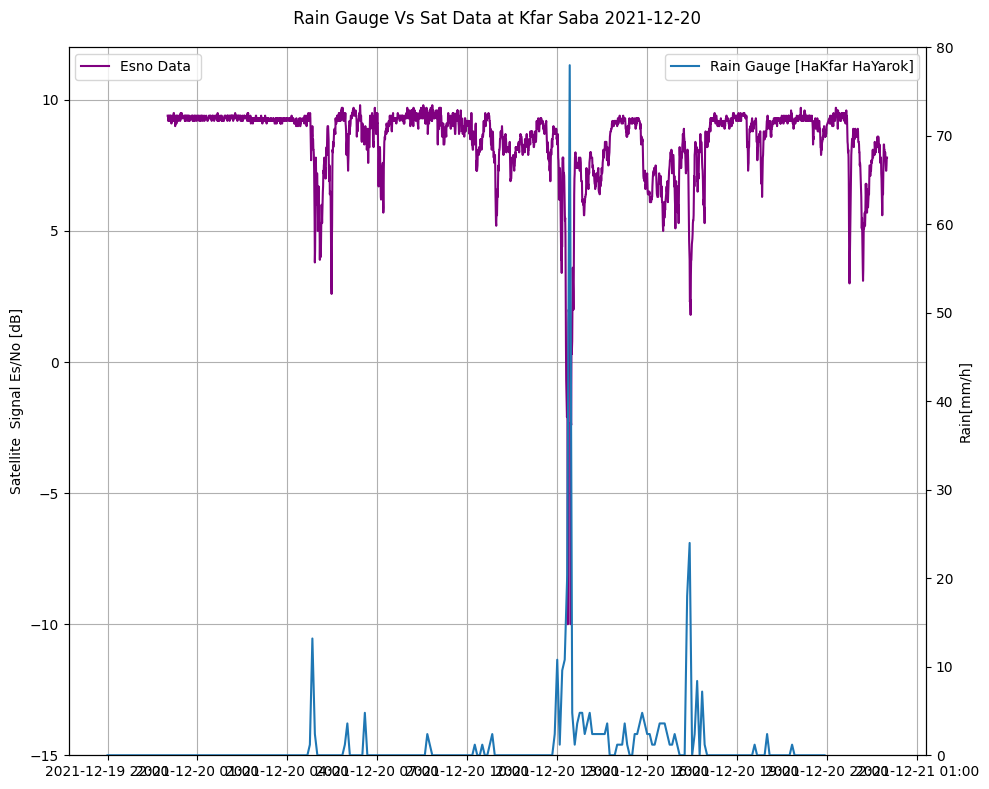

In [9]:
Date= date(2021, 12, 20)

RainDF=pd.read_csv(os.path.join(FSat.chilPath, 'RainDF.csv'))
SatDF=pd.read_csv(os.path.join(FSat.chilPath, 'SatDF.csv'))


Rain=FSat.LoadRainDataCSV(RainDF,Date)
Sat=FSat.LoadSatDataCSV(SatDF,Date)
FSat.PlotRainVsSatData(Rain,Sat)

2. Try to implement the rain estimation algorithem without wet antenna  elimination and plot the result  

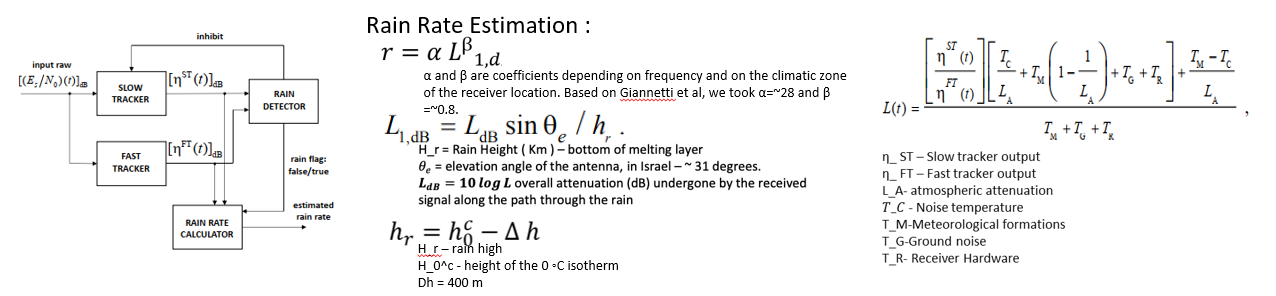


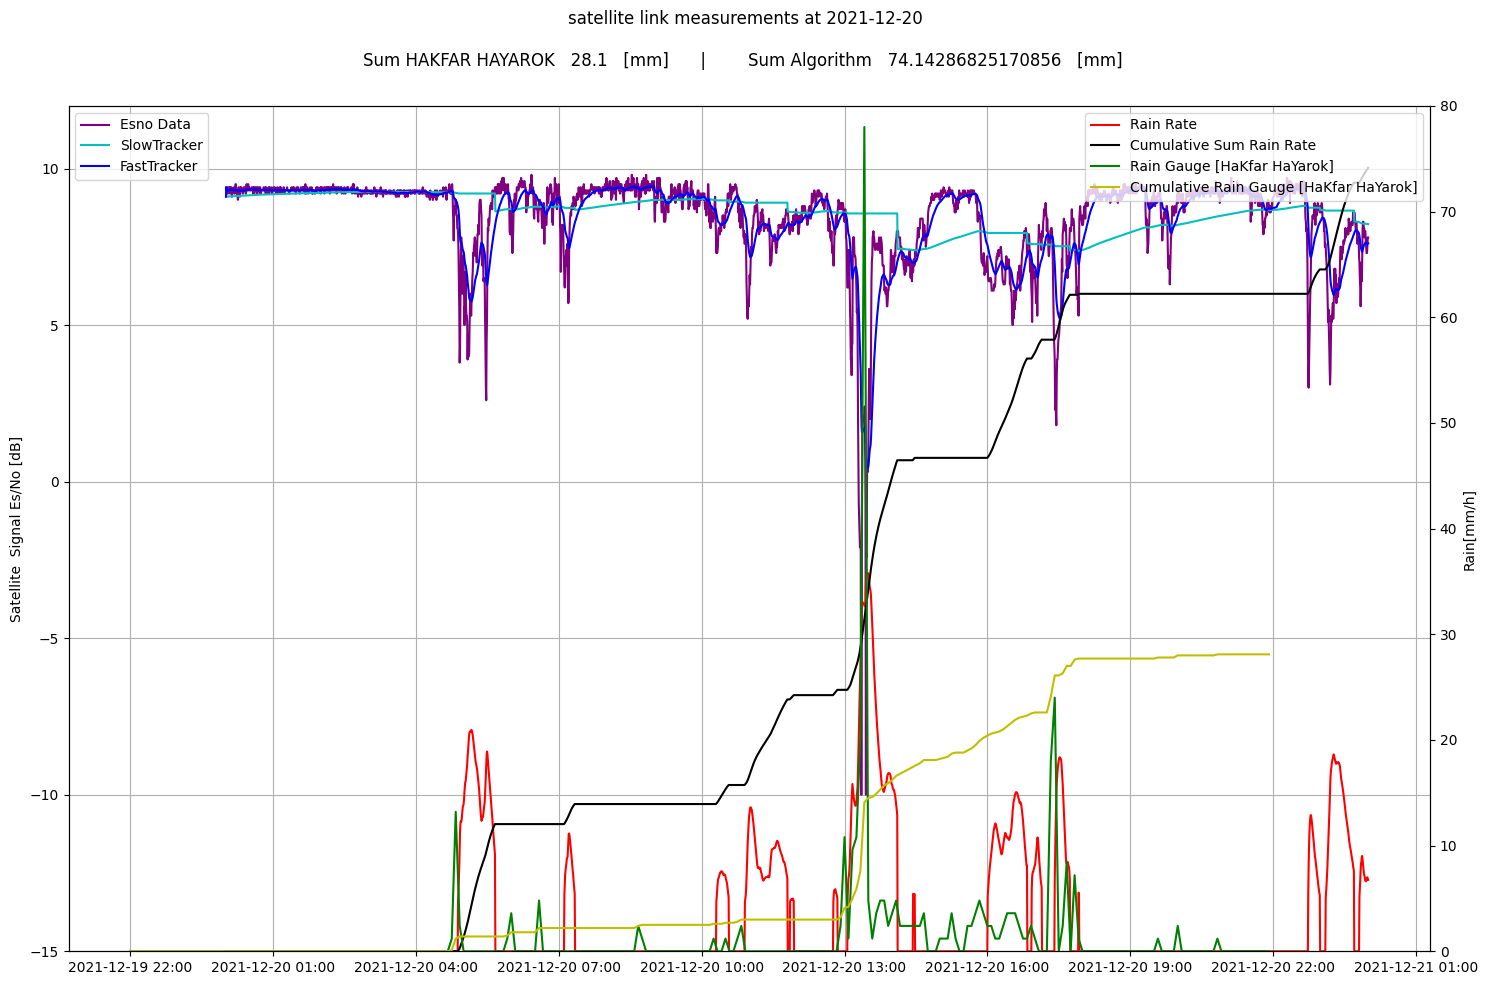

In [10]:
DataIn=Sat.esno.to_numpy()

ST = FSat.Kalman_ST(DataIn)
FT = FSat.Kalman_FT(DataIn)
[FT,ST,Diff_Rain_Flag]=FSat.ApplySTMask(FT, ST)
L=FSat.Calc_L(FT, ST)
RainRate_org=FSat.ApplyPowerLaw(L)
[RainEstimated,RainEstimated_mmhr]=FSat.ApplyDiffMask(RainRate_org,Diff_Rain_Flag)

FSat.PlotRainEstimationVsGaugeData(RainEstimated,Rain,Sat,ST,FT)







Compare yoour results with the estimator function



2021_12_20


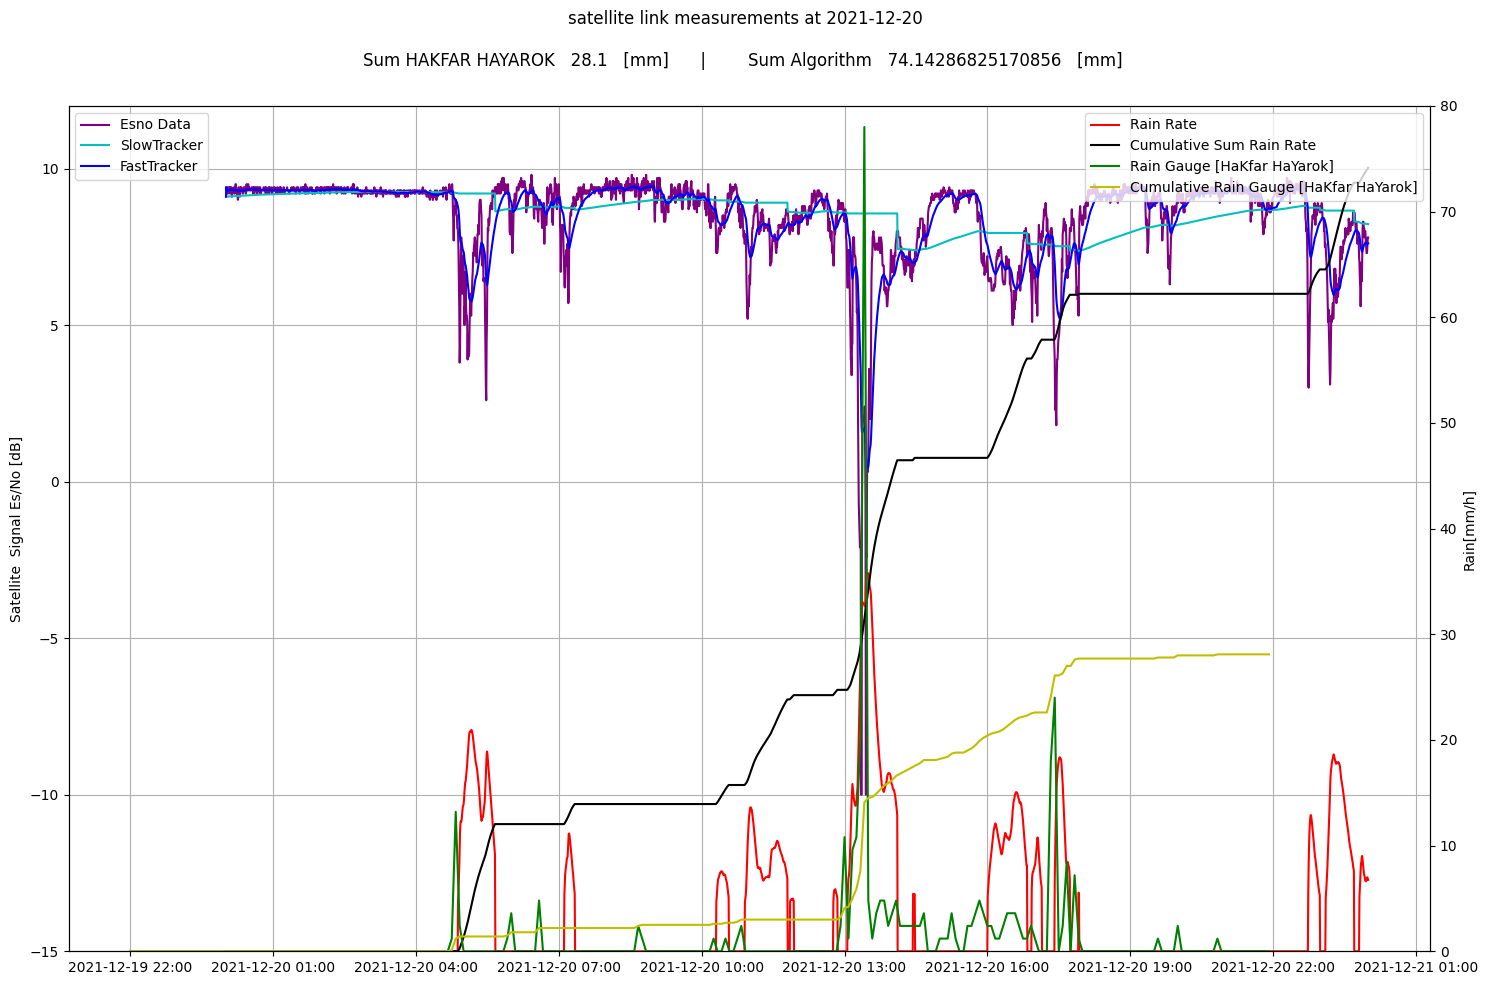

In [11]:
[RainEstimated,ST,FT]=FSat.RainEstimator(Date,Sat)
FSat.PlotRainEstimationVsGaugeData(RainEstimated,Rain,Sat,ST,FT)


Apply pre processing on the satlite signal and try to explain the improvment in the results  

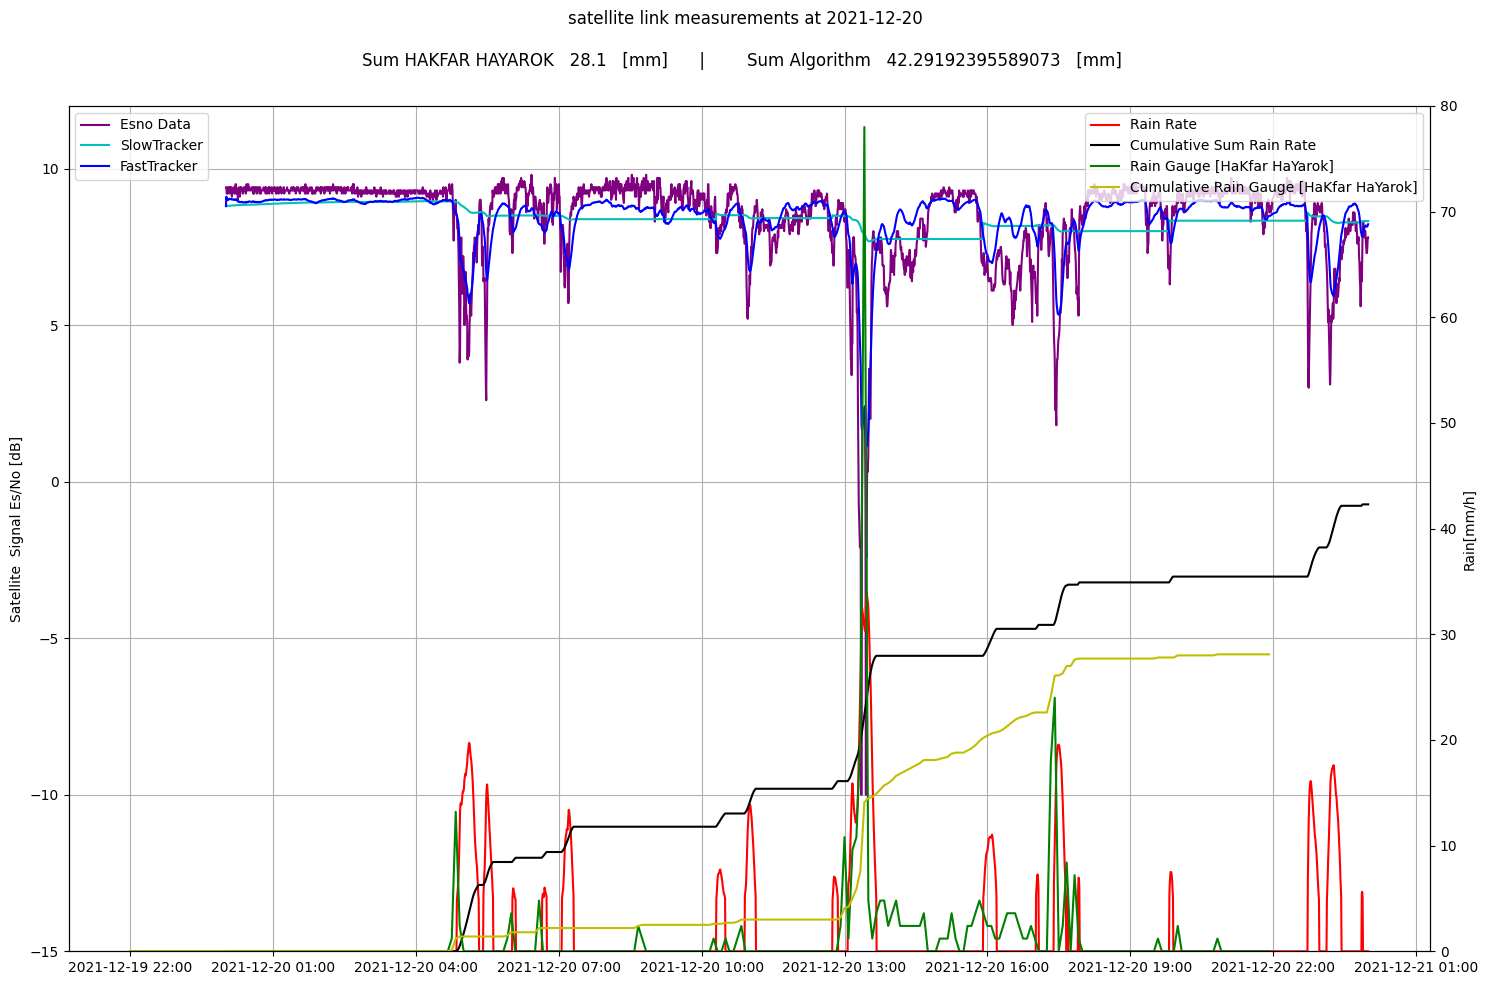

In [13]:
DataIn=Sat.esno.to_numpy()
DataIn=FSat.SatDataPreProcessing(DataIn)

ST = FSat.Kalman_ST(DataIn)
FT = FSat.Kalman_FT(DataIn)
[FT,ST,Diff_Rain_Flag]=FSat.ApplySTMask(FT, ST)
L=FSat.Calc_L(FT, ST)
RainRate_org=FSat.ApplyPowerLaw(L)
[RainEstimated,RainEstimated_mmhr]=FSat.ApplyDiffMask(RainRate_org,Diff_Rain_Flag)

FSat.PlotRainEstimationVsGaugeData(RainEstimated,Rain,Sat,ST,FT)

In [ ]:
Sat.esno=FSat.SatDataPreProcessing(Sat.esno.to_numpy())
[RainEstimated,ST,FT]=FSat.RainEstimator(Date,Sat)
FSat.PlotRainEstimationVsGaugeData(RainEstimated,Rain,Sat,ST,FT)

loop over the DB between  16-11-2021 till 23-12-2021 and calculate the RMSE  of

*   List item
*   List item

the estimation Vs Rain Gauge result  

In [ ]:
start_date= date(2021, 11, 16)
end_date= date(2021, 12, 23)
EstError=[]
for Date in FSat.daterange(start_date, end_date):
  Rain=FSat.LoadRainData(Date)
  Sat=FSat.LoadSatData(Date)
  [RainEstimated,ST,FT]=FSat.RainEstimator(Date,Sat)
  RainGaugSum=np.sum(Rain.value/12)
  EstRainSum=np.sum(RainEstimated/120)
  EstError .append(np.abs(RainGaugSum - EstRainSum))

RMSE_NOAnt=np.power( np.sum(np.power(EstError,2))/len(EstError),0.5)

print( " RMSE No Ant  " + str(RMSE_NOAnt))

fig, ax = plt.subplots()
ax.plot(EstError,'-o', color='r', label="Rain estimation Error without pre-processing")
ax.grid()
ax.legend()
plt.ylabel('Rain Estimation Error [mm/day]')
plt.show()

loop over the DB and apply Satlite signal pre processing  

In [ ]:
start_date= date(2021, 11, 16)
end_date= date(2021, 12, 23)
EstError_WetAnt=[]
for Date in FSat.daterange(start_date, end_date):
  Rain=FSat.LoadRainData(Date)
  Sat=FSat.LoadSatData(Date)
  Sat.esno=FSat.SatDataPreProcessing(Sat.esno.to_numpy())
  [RainEstimated,ST,FT]=FSat.RainEstimator(Date,Sat)
  RainGaugSum=np.sum(Rain.value/12)
  EstRainSum=np.sum(RainEstimated/120)
  EstError_WetAnt .append(np.abs(RainGaugSum - EstRainSum))

RMSE_AntElim=np.power( np.sum(np.power(EstError_WetAnt,2))/len(EstError_WetAnt),0.5)

print( " RMSE With Wet Antenna Elimination   " + str(RMSE_AntElim))

fig, ax = plt.subplots()
ax.plot(EstError,'-*', color='b', label="Rain estimation Error without pre-processing")
ax.plot(EstError_WetAnt,'-o', color='r', label="Rain estimation Error with  pre-processing")
ax.grid()
ax.legend()
plt.ylabel('Rain Estimation Error [mm/day]')
plt.show()